<a href="https://colab.research.google.com/github/plurbius/DC_Bike_Routing/blob/main/OSM_Bike_Routing_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Bike Routing Script for Washington, DC

## Project Outline

The objective of this project is to design and develop a lightweight, open-source routing application tailored specifically for bicyclists in Washington, DC. The tool will allow users to input a start and end location and return an optimized bike-friendly route based on criteria such as the presence of bike lanes, road speed limits, elevation, and distance.

This application will aim to provide a user-friendly and locally focused tool that utilizes open geospatial data and routing libraries, with the potential for further expansion to other cities or routing criteria. The tool will be accessible via a simple web interface built using free and open-source technologies.

The original project Terms of Reference (TOR) can be found [here](https://docs.google.com/document/d/1bPrJ1X7donRtVv7jnUrzMzGBmkQQa8nq/edit?usp=sharing&ouid=107520576799289775393&rtpof=true&sd=true).

### Project Outputs
 The following deliverables will be produced:
- A functioning Python-based routing tool with a user interface.
- A spatial dataset representing the DC bike network with relevant routing attributes.
- GitHub repository with all source code and documentation


### Methodology
Data Sources:
- DC Open Data portal (elevation, speed limits)
- OpenStreetMap (road geometry and attributes)

Relevant Libraries:
- OSMnx for street network extraction from OSM
- ORS for determining routing preferences
- GeoPandas/Folium for spatial data handling and visualization


The workflow for this project will utilize the bike network that exists in OpenStreetMaps. This network can be downloaded using OSMnx and used to create a bike routing graph which will serve as the skeleton for this tool. OpenRouteService will then be used to assign routing preferences to the graph. Before this occurs, tools like GeoPandas will have to be used to incorporate additional attributes such as **road slope** and **speed limits** into the bike routing graph dataset. Lastly, Folium is an open-source visualization tool that meshes well with Streamlit, an open source publishing tool. There are examples of relevant workflows in OSMnx, ORS, and Streamlit libraries available on GitHub.

The bike routing graph will be weighted using customizable criteria (e.g., road safety, slope, lane presence) and routes will be computed between user-specified start and end points. Elevation data will be included to help avoid steep climbs, and routing preferences can be modified to prioritize either shortest or safest routes.

## Out-Of-The-Box Mapping with ORS

OpenRoutingService ([ORS](https://openrouteservice.org/services/)) is an out of the box option that lets you quickly take an origin and destination and plot a route with it - super handy!

ORS uses openstreetmap ([OSM](https://www.openstreetmap.org/)) data that is available for free online. ORS pulls in this data and allows for immediate routing depending on the prefered transportation type of the user.

In [ ]:
# Necessary libraries for this workflow
!pip install openrouteservice
!pip install pandas
!pip install folium
!pip install osmnx
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Geocoding logic for addresses based off of input points
# This also enables users to input specific orrigin and destination addresses
# For this example, lets predict a route from Samson Hall to Stadium-Armory metro station
# Samson Hall - 2036 H St NW, Washington, DC 20052
# Stadium-Armory Metro - 192 19th St SE, Washington, DC 20003
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="geo_app")

address1 = input("Enter the starting address:")
address2 = input("Enter the ending address: ")
def get_coordinates(address):
  try:
    location = geolocator.geocode(address, timeout=10)
    if location:
      return (location.latitude, location.longitude)
    else:
      return ("Not found", "Not found")
  except Exception as e:
    return (str(e), str(e))

lat1, lon1 = get_coordinates(address1)
time.sleep(1)
lat2, lon2 = get_coordinates(address2)

origin = [lon1, lat1]
destination = [lon2, lat2]

print(origin)
print(destination)

Enter the starting address:2036 H St NW, Washington, DC 20052
Enter the ending address: 192 19th St SE, Washington, DC 20003
[-77.0463311, 38.8993741]
[-76.9770859, 38.888334]


In [ ]:
import openrouteservice as ORS
import pandas as pd
import folium

# Initialize ORS client
ORS_API_KEY = 'API_Key'
client = ORS.Client(key=ORS_API_KEY)

# Get the cyling related data from OSM
route = client.directions(
    coordinates=[origin, destination],
    profile='cycling-regular',  # 'cycling-mountain', 'cycling-road', 'cycling-electric'
    format='geojson',
    radiuses=[100, 100]
)

In [ ]:
# Extract coordinates from route geometry
coords = route['features'][0]['geometry']['coordinates']
bounds = [[min(p[1] for p in coords), min(p[0] for p in coords)],
          [max(p[1] for p in coords), max(p[0] for p in coords)]]

# Create map and fit to bounds
m = folium.Map()
folium.GeoJson(route, name="route").add_to(m)
m.fit_bounds(bounds)

# Add start/stop markers
folium.Marker(location=[origin[1], origin[0]], popup="Start", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(location=[destination[1], destination[0]], popup="End", icon=folium.Icon(color="red")).add_to(m)

m.save("bike_route_map.html")
m

The con of using a prepackaged routing model like the one found through ORS is that you cannot cutomize the weights within the routing logic.

Other python libaries, such as OSMnx, enable the development of customizable routes that can be configured with specific preferences such as the presence of bike lanes, slope of the route, the speed limits along the route, and the shortest distance between the starting and end points. Utilizing the route weighting capabilities of OSMnx enables the development of user specific routing models. Say a biker does not like steep climbs along their bike rides due to an injury. A routing model that prioritizes low slope routes would enable a user like this to get out and bike while still providing a route that is acomplishable based on the users preferences.

## Developing A Custom Bike Routing Tool

### Part 1: Download the Data

In order to create a custom, other tools besides ORS must be used. Part 1 of this workflow utilizes the OSMnx module to download bike data from OSM locally. This is essential for the development of a route with custom routing weights. The output graph you see at the end of this code block is the bicycle-related data for DC downloaded from OSM.

In [ ]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Download and project the bike network (Takes ~2 Minutes)
place_name = "Washington, District of Columbia, USA"
G = ox.graph_from_place(place_name, network_type='bike')
G_proj = ox.project_graph(G)

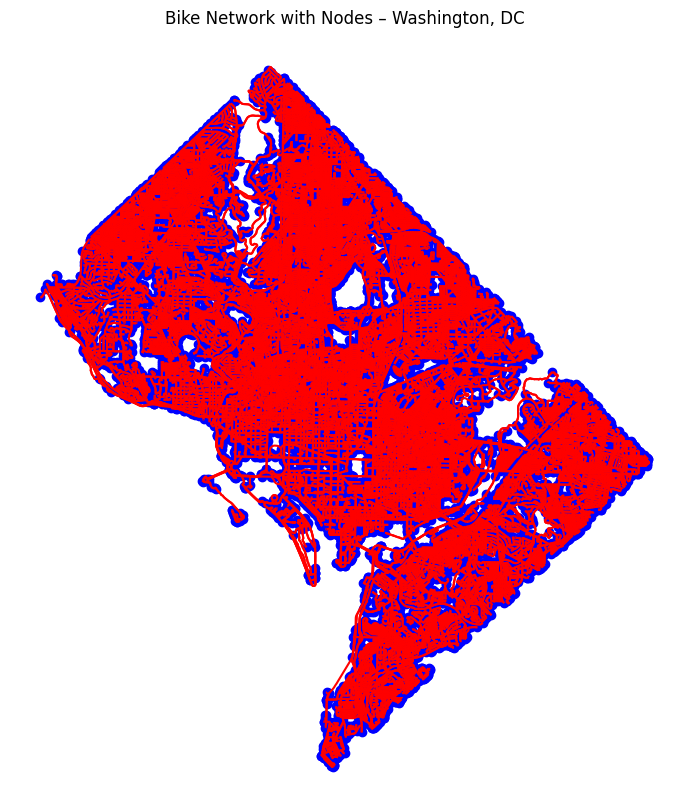

In [ ]:
# Convert lines to GeoDataFrames
edges = ox.graph_to_gdfs(G_proj, nodes=False)

# Ensure optional columns exist
for col in ['cycleway', 'bicycle']:
    if col not in edges.columns:
        edges[col] = np.nan

# Filter for bike-related edges
bike_edges = edges[
    edges['highway'].notnull() & (
        edges['cycleway'].notnull() | edges['bicycle'].notnull()
    )
]

# Save to GeoJSON
bike_edges.to_file("dc_bike_lanes.geojson", driver="GeoJSON")

# Plot the graph
edges_all, nodes_all = ox.graph_to_gdfs(G_proj)
fig, ax = plt.subplots(figsize=(10, 10))
edges_all.plot(ax=ax, linewidth=1, color='blue')
nodes_all.plot(ax=ax, color='red', markersize=5)
plt.title("Bike Network with Nodes – Washington, DC")
plt.axis('off')
plt.show()

edges_all.to_file("dc_all_bike_network_line.geojson", driver="GeoJSON")
nodes_all.to_file("dc_all_bike_network_point.geojson", driver="GeoJSON")

Now that the bike network for DC has been downloaded, supplemental data like route slope and speed limits can be incorporated into the dataset and weighting scheme.

### Part 2: Add elevation data to the network

The next portion of the workflow will deatil how elevation data was added to the bike network graph. The input data used for this analysis was an elevation point dataset available on the DC Open Data portal.

In [ ]:
# Read in elevation point data from DC Data Portal and reproject them
import geopandas as gpd

elevation_points = gpd.read_file("https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Elevation_WebMercator/MapServer/1/query?outFields=*&where=1%3D1&f=geojson")

elevation_points = elevation_points.to_crs(G_proj.graph['crs'])

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Get nodes
nodes, edges = ox.graph_to_gdfs(G_proj)

# Spatial join nodes with elevation points
nodes['geometry'] = nodes.geometry

# Use sjoin_nearest function to find the closest elevation point to each node in the bike network
nodes_with_elev = gpd.sjoin_nearest(nodes, elevation_points[['ELEVATION', 'geometry']], how='left', distance_col='dist_to_elev')

# Add elevation field and fill values forward if missing
nodes_with_elev['ELEVATION'] = nodes_with_elev['ELEVATION'].fillna(method='ffill')

<ipython-input-155-7cfc7b6ba29e>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nodes_with_elev['ELEVATION'] = nodes_with_elev['ELEVATION'].fillna(method='ffill')


In [ ]:
node_elevations = nodes_with_elev['ELEVATION'].to_dict()

# Add slope to each bike network edge segment.
# This is done by taking the elevation assigned to each node in the bike network,
# subtracting the elevation values at the starting and ending points of the edge segments,
# and dividing that difference in elevation by the length of the edge segment
for u, v, k, d in G_proj.edges(keys=True, data=True):
    elev_u = node_elevations.get(u)
    elev_v = node_elevations.get(v)
    if elev_u is not None and elev_v is not None and 'length' in d:
        rise = elev_v - elev_u
        run = d['length']
        slope = rise / run if run != 0 else 0
        d['slope'] = slope
    else:
        d['slope'] = 0  # Assume flat if missing

In [ ]:
# Adds updated nodes and edges to the project graph
nodes, edges = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)

In [ ]:
# Edges with a slope other than 0
edges[(edges['slope'] != 0)]


,,,osmid,highway,lanes,maxspeed,name,oneway,reversed,length,slope,geometry,service,ref,access,bridge,junction,tunnel,width,est_width
u,v,key,,,,,,,,,,,,,,,,,,
1379442096,2587508229,0,86982251,residential,NaN,NaN,Hamilton Street Northwest,False,True,77.053059,1.091326,"LINESTRING (325031.892 4313516.857, 325109.124...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2591033498,2591033496,0,86982245,residential,NaN,NaN,Hamilton Street Northwest,False,False,66.136316,-0.019808,"LINESTRING (324733.036 4313512.561, 324666.75 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2591033496,2591033498,0,86982245,residential,NaN,NaN,Hamilton Street Northwest,False,True,66.136316,0.019808,"LINESTRING (324666.75 4313511.357, 324733.036 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1443727170,1361078184,0,86982245,residential,NaN,NaN,Hamilton Street Northwest,False,False,42.475557,-0.185283,"LINESTRING (324476.845 4313507.893, 324468.813...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013430012,49790324,0,132601119,tertiary,2,25 mph,Illinois Avenue Northwest,False,False,101.614578,-0.077450,"LINESTRING (324475.147 4313546.55, 324436.091 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12741157369,12741157362,0,1376084320,service,NaN,NaN,NaN,False,True,36.046623,-0.154800,"LINESTRING (326947.707 4302056.11, 326911.6 43...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12741157381,12741157377,0,1376084323,service,NaN,NaN,NaN,False,False,81.647834,0.211763,"LINESTRING (326895.728 4302175.11, 326977.489 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12741157377,12741157381,0,1376084323,service,NaN,NaN,NaN,False,True,81.647834,-0.211763,"LINESTRING (326977.489 4302171.414, 326895.728...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Part 3: Create Weighting

Part 3 of the workflow details the weighting scheme used for the custom routing model. The model is designed to seek out a route that has a short distance, bike lanes, a low speed limit, and a low grade.

In [ ]:
import networkx as nx
import osmnx as ox

# custom_bike_weight() function created
def custom_bike_weight(u, v, d, penalize_speed=True):  # Add penalize_speed as an argument
    # Base values
    length = d.get('length', 1)
    slope = abs(d.get('slope', 0))  # take absolute value, penalize both up and down as we are loking for flat areas
    bike_lane = d.get('cycleway', None)

    # Weight components, want the lowest value
    length_weight = length # base travel distance, shorter is better
    slope_penalty = slope * 100  # stronger penalty for steeper segments, given as percent
    bike_lane_bonus = -50 if bike_lane else 0  # HIGHLY reward bike lanes with negative weight
    speed_limit = d.get('maxspeed', 25)  # Default to 25 mph if not found
    speed_penalty = speed_limit if penalize_speed else 0  # Apply penalty conditionally

    # Final weight
    weight = length_weight + slope_penalty + bike_lane_bonus + speed_penalty
    return weight

In [ ]:
from pyproj import Transformer
from geopy.geocoders import Nominatim
import time

# Initialize the geocoder
geolocator = Nominatim(user_agent="geo_app")

# Get addresses from user input
address1 = input("Enter the starting address: ")
address2 = input("Enter the ending address: ")

# Function to get coordinates
def get_coordinates(address):
  try:
    location = geolocator.geocode(address, timeout=10)
    if location:
      return (location.longitude, location.latitude)  # Notice the order (lon, lat)
    else:
      return ("Not found", "Not found")
  except Exception as e:
    return (str(e), str(e))

# Get coordinates for origin and destination
origin_lonlat = get_coordinates(address1)
time.sleep(1)  # Add a delay to avoid overloading the geocoding service
destination_lonlat = get_coordinates(address2)

# Check if geocoding was successful
if origin_lonlat[0] == "Not found" or destination_lonlat[0] == "Not found":
  print("Error: Could not geocode one or both addresses. Please check your input.")
else:
  # Set up the transformer
  transformer = Transformer.from_crs("epsg:4326", "epsg:32618", always_xy=True)

  # Project to UTM meters
  origin_x, origin_y = transformer.transform(*origin_lonlat)
  destination_x, destination_y = transformer.transform(*destination_lonlat)

Enter the starting address: 2036 H St NW, Washington, DC 20052
Enter the ending address: 192 19th St SE, Washington, DC 20003


In [ ]:
# Creates route based off of the node closest to the geocoded point using the weighting scheme outlined above
orig_node = ox.distance.nearest_nodes(G_proj, X=origin_x, Y=origin_y)
dest_node = ox.distance.nearest_nodes(G_proj, X=destination_x, Y=destination_y)
route = nx.shortest_path(G_proj, orig_node, dest_node, weight=custom_bike_weight)

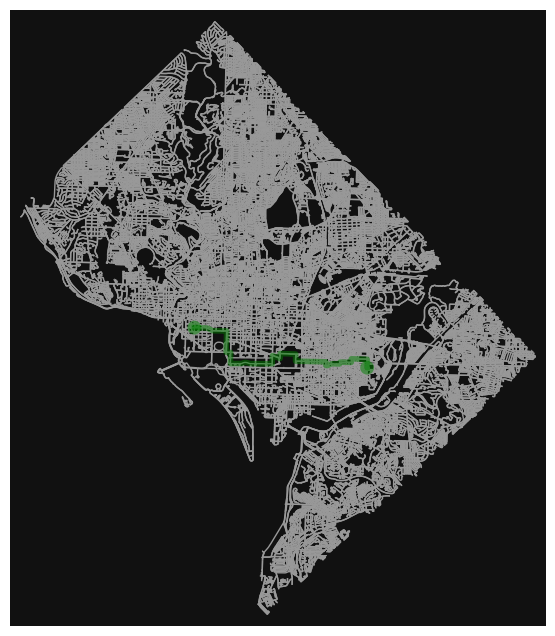

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Initial Plot
ox.plot_graph_route(G_proj, route, route_color='green', route_linewidth=4, node_size=0)

### Part 4: Create Online Plot

In this portion of the workflow, the route derived using the weighting scheme created in Part 3 is published to the web as an html file.

In [ ]:
# Get the route edges (pairs of nodes)
route_edges = list(zip(route[:-1], route[1:]))

In [ ]:
# Get edges GeoDataFrame
from shapely.geometry import LineString
nodes, edges = ox.graph_to_gdfs(G_proj)
# Filter edges that are in the route
route_edge_lines = []

for u, v in route_edges:
    try:
        edge_data = G_proj.get_edge_data(u, v, 0)  # get the edge data
        if 'geometry' in edge_data:
            route_edge_lines.append(edge_data['geometry'])
        else:
            # If no geometry, create a straight line
            point_u = (G_proj.nodes[u]['x'], G_proj.nodes[u]['y'])
            point_v = (G_proj.nodes[v]['x'], G_proj.nodes[v]['y'])
            route_edge_lines.append(LineString([point_u, point_v]))
    except:
        continue

In [ ]:
from shapely.geometry import MultiLineString

# Combine all small lines into a MultiLineString
route_multiline = MultiLineString(route_edge_lines)

# Make a GeoDataFrame from multi line
route_gdf = gpd.GeoDataFrame(geometry=[route_multiline], crs=G_proj.graph['crs'])

# Reproject to EPSG:4326 for Folium
route_gdf = route_gdf.to_crs(epsg=4326)

In [ ]:
import folium
# Center map at the start point
start_coords = [route_gdf.geometry.centroid.y.iloc[0], route_gdf.geometry.centroid.x.iloc[0]]

# Create Folium Map
m1 = folium.Map(location=start_coords, zoom_start=13, tiles="OpenStreetMap")

# Add route
folium.GeoJson(
    route_gdf,
    name="bike_route",
    style_function=lambda x: {
        "color": "green",
        "weight": 5,
        "opacity": 0.8
    }
).add_to(m1)

# Add start/stop markers
folium.Marker(
    location=[origin_lonlat[1], origin_lonlat[0]],  # (lat, lon) format
    popup="Start",
    icon=folium.Icon(color="green"),
).add_to(m1)

folium.Marker(
    location=[destination_lonlat[1], destination_lonlat[0]],  # (lat, lon) format
    popup="End",
    icon=folium.Icon(color="red"),
).add_to(m1)

# Add LayerControl to the folium map, save the map, and open it in a browser
folium.LayerControl().add_to(m)
m1.save("bike_route_map.html")
import webbrowser
webbrowser.open("bike_route_map.html")
m1


<ipython-input-167-efc832455f7b>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  start_coords = [route_gdf.geometry.centroid.y.iloc[0], route_gdf.geometry.centroid.x.iloc[0]]


Above is the routing output for the OSMnx custom model. To access the web map, go into the output folder associated with your route and download the bike_route_map.html file file. You will then be able to open the route with a map in a browser.

*In google Collab, this will be in the content folder. Optionally, you can push this to a google drive folder. *  

### Part 5: Publishing to GitHub

This was made easy using the google Collab GitHub publishing tools. The respository containing this workflow can be accessed [here](https://github.com/plurbius/custom-bike-routing/tree/main).

##Limitations and Conclusions

### **Limitations**

There were several major limitations to the project including: the order in which the routing logic occurs, the way slope was derived, and the user experience of the end web map.

#### Routing Logic Order
One issue that arose was that weighting scheme was prioritized over the shortest distance between two points and it was difficult to incorporate a weight that successfully took into consideration distance from the destination. The reason for this is that the nx.shortest_route function, which is used to determine the shortest route in the OSMnx libary, passes the weight scheme through the function. A solution to this could be to create a weighting heuristic using euclidean distance to the destination.

#### Slope
Slope was derived using a point dataset due to processing constraints. Ideally, slope would be calculated on the fly using a digital elevation model (DEM) each time a route is called. This process would enable directional grades, enabling a preferrence for downhill, and potentially more granular elevation data. This was the workflow used in this project.

Point data from an elevation survey of DC (2ft contour resolution) was used because of data contraints compared to using a several hundered MB DEM. This forced the research team to get creative with tying the elevation data to the bike network, eventually being achieved using a tool that performed a spatial join on the nearest survey point to each route node. This resulted in much of the route dataset having default slopes of 0, which is a large assumption. This issue would be remedied with a raster based approach, but more work needs to be done exploring where the slope calculation should take place in the workflow.

The fact that the slope was calculated independently of the route meant that directionality could not be taken into consideration in this model. As a result, the model was designed to prioritize flatter routes. Creating route-specific grade profiles would allow for the prioritization of downhills which could help make the route more efficient.

#### User Experience
The project group was unable to get a fully functioning web map in this deliverable. Instead, the main deliverable is a webmap that can be opened on mobile devices and shared. While this format meets the minimum standards for producing a shareable route on a basemap, user experience could definitely be improved to include on screen user interactions and other features seen in routing apps like google or apple maps. This could come with doing more work in the streamlit and folium libraries.

### **Conclusions**

In [ ]:
# ORS Route
m

In [ ]:
# OSMnx Route
m1

When comparing the ORS derived route to the custom route devised in this workflow using OSMnx in the maps above, the models result in outputs that are quite different. The ORS model is designed to prioritize the shortest distance between two points - similar to the routing techniques used by large scale routing apps such as Google or Apple maps. The custom weighting scheme designed in this workflow emphasizes the importance of bike lanes, low grades, and low speeds in the creation of its routes.

Most bikers will probably continue to choose the quickest route as their preferred route, especially when out-of-the-box open source tools like ORS work so well, but the route customizability offered by the OSMnx library enables a new degree of freedom for users. The route designed in this project prioritizes safety and accessibility in its logic, which could very much be a priority for some cyclists.

With more development, this routing logic could be incorporated into an app that gives users an open source alternative to proprietary mapping apps. Similar to how google maps gives multiple routing options that maximize speed or fuel efficiency, this open source bike route could enable users to cutomize their routes beyond just the shortest distance, and include other important considerations like safety and accessibility.